# Instalacion e importacion de librerias

In [30]:
! pip install opendatasets --user
! pip install folium --user
! pip install statsmodels --user

In [31]:
import opendatasets as od
import pandas as pd
import requests
import folium
from folium import Marker
from folium.plugins import HeatMap
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings('ignore')

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
dataset_url='https://www.kaggle.com/datasets/juanmartnrodrguez/argentina-dataset-propiedades'
od.download(dataset_url)

Skipping, found downloaded files in ".\argentina-dataset-propiedades" (use force=True to force download)


# Introduccion


**Contexto Empresarial:** Eres un cientifico de datos de una organizacion. Dicha organizacion se dedica al desarrollo inmobiliario a lo largo de Argentina. El modelo de negocio es comprar terrenos, contratar a una constructora, desarrollar y vender o alquilar propiedades. En los ultimos años la empresa no ha tenido exito en las ventas y en los lugares a desarrollar. La gerencia plantea la hipotesis de que localidad o provincia tiene mayor rentabilidad para desarrollar negocios inmobililarios.

**Problema Empresarial:** El equipo de ventas junto con la gerencia se acerca hacia nosotros para responder la siguiente pregunta: ¿Cual es la mejor zona para desarrollar propiedades que se puedan vender rapido?, si es asi, ¿Que tipo de propiedades se suelen vender mas rapido?

**Contexto Analitico:** El departamento de ventas nos ha provisto una base de datos con todas las ventas de propiedades en Argentina que contiene atributos como fecha de inicio de publicacion de la propiedad, fecha de fin de la publicacion de la propiedad, precio de venta,cantidad de ambientes, baños, superficie total y cubierta, y mas. Veremos que con una regresion lineal podemos cuantificar la correlacion entre la variable dependiente (tipo de propiedad) y las variables dependientes (Precio, tiempo en el mercado, cantidad de baños, habitaciones,etc.)

El caso esta estructurado de la siguiente manera: (1) realizaremos un analisis de datos explotaratorio para investigar visualmente rangos de precio para distintos tipos de propiedades, cantidad de propiedades vendidas por provincias y diferencias entre localidades. (2) utilizar los conocimientos sobre regresion lineal para ajustar el modelo y finalmente (3) abordar el tema principal de la hipotesis.

# Exploracion de datos

In [34]:
df = pd.read_csv('./argentina-dataset-propiedades/ar_properties.csv')
df.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,wdQ5hWhv8P14T7Sh9g4QCg==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-32.716652,-68.642692,Argentina,Mendoza,NaN,...,NaN,350.0,350.0,NaN,NaN,NaN,Excelentes Lotes Sobre Ruta 34,Corredor Responsable: VICTOR E. MONTIVERO - C....,Lote,Venta
1,nnMBYZ4RMRY+vm753EtA+g==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-24.797723,-65.467514,Argentina,Salta,NaN,...,NaN,1541.0,1541.0,NaN,NaN,Mensual,TERRENO + VENTA + JARDINES DE SAN LORENZO +150...,Corredor Responsable: Pablo Castañeda - C.U.C....,Lote,Venta
2,+dnVA1K6JxzL1zAjOEQ1pA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919373,-58.020591,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
3,dLHXKN5/sRZpm9Yk0yI2nA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919455,-58.024807,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
4,wtw/k887EPipd37UYHKb1Q==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-34.364924,-58.783143,Argentina,Bs.As. G.B.A. Zona Norte,Escobar,...,NaN,18164.0,18164.0,NaN,NaN,Mensual,PANAMERICANA 47300,Nave principal 66 x 90 m: 6005 m2 cubiertos...,Otro,Venta


In [35]:
df.shape

(1000000, 25)

In [36]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

Las variables disponibles son:

- type - Tipo de aviso (Propiedad, Desarrollo/Proyecto).
- id - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.
- start_date - Fecha de alta del aviso.
- end_date - Fecha de baja del aviso.
- created_on - Fecha de alta de la primera versión del aviso.
- place - Campos referidos a la ubicación de la propiedad o del desarrollo.
    - lat - Latitud.
    - lon - Longitud.
    - l1 - Nivel administrativo 1: país.
    - l2 - Nivel administrativo 2: usualmente provincia.
    - l3 - Nivel administrativo 3: usualmente ciudad.
    - l4 - Nivel administrativo 4: usualmente barrio.
- property - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto).
    - operation - Tipo de operación (Venta, Alquiler).
    - type - Tipo de propiedad (Casa, Departamento, PH).
    - rooms - Cantidad de ambientes (útil en Argentina).
    - bedrooms - Cantidad de dormitorios (útil en el resto de los países).
    - bathrooms - Cantidad de baños.
    - surface_total - Superficie total en m².
    - surface_covered - Superficie cubierta en m².
    - price - Precio publicado en el anuncio.
    - currency - Moneda del precio publicado.
    - price_period - Periodo del precio (Diario, Semanal, Mensual)
    - title - Título del anuncio.
    - description - Descripción del anuncio.
- name - Nombre del desarrollo.
- description - Descripción del anuncio.

Primero filtrar por las caracteristicas que precisamos:

- Que sea de Argentina
- Que la propiedad este terminada y vendida
- Que sea una propiedad; que no sea Desarrollo o proyecto
- Que en el precio no este en nulo y que esté en dolares

In [37]:
df = df[(df['l1'] == 'Argentina') & (df['currency'] == 'USD') & (df['operation_type'] == 'Venta')]


Cambio de formato en columnas de fecha, reemplazo de datos con fecha indefinida (para no exceder el Timestamp) y creación de una nueva columna informando sin finalizó, o no, el anuncio.

In [38]:
from datetime import date
from datetime import datetime

In [39]:
today = date.today()
now = datetime.now()

In [40]:
df.columns
pd.Timestamp.max

Timestamp('2262-04-11 23:47:16.854775807')

In [41]:
df = df.replace({"9999-12-31" : "2250-12-31"})

In [42]:
df['finalizo_anuncio'] = np.where(df['end_date'] == '2250-12-31', 'No', 'Si')

In [43]:
df['start_date'] = pd.to_datetime(df['start_date'], format = '%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')
df = df[df['finalizo_anuncio'] == 'Si']


Una vez filtrados los datos ya cumplimos las especificaciones principales, que se haya vendido, que sea de Argentina y que el precio sea en USD.

Ahora hay que pasar a limpiar la data de valores nulos y poner los tipos de datos como corresponden

In [44]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type',
       'finalizo_anuncio'],
      dtype='object')

In [45]:
#Sacar NA
df = df.dropna(subset=['price','surface_total','surface_covered','price_period','bathrooms','bedrooms','rooms'])
df.head(5)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,finalizo_anuncio
131,L2WYRjQu5PA9QzlodPmAXg==,Propiedad,2020-12-25,2021-01-13,2020-12-25,-34.918987,-57.939761,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,43.0,41.0,45000.0,USD,Mensual,Venta depto. 1 dormitorio - Av. 60 esq. 5 - La...,"Piso alto, excelente vista y luminosidad. Livi...",Departamento,Venta,Si
371,wYQvnyjYy7Z2E0XNkLneGA==,Propiedad,2020-12-26,2021-03-08,2020-12-26,-34.562809,-58.476758,Argentina,Capital Federal,Congreso,...,49.0,46.0,74000.0,USD,Mensual,¡¡Excelente 2 ambientes!!,"Luminoso dos ambientes!, ubicado a una cuadra ...",Departamento,Venta,Si
376,hxdT2Fv5cifKndBxN/nsiQ==,Propiedad,2020-12-26,2021-01-05,2020-12-26,-34.918933,-57.930270,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,64.0,56.0,85000.0,USD,Mensual,Departamento - La Plata,Departamento 1 dormitorio 64 mts cubiertos apr...,Departamento,Venta,Si
379,5WOhu6n1dSQfgnQTy2gZCA==,Propiedad,2020-12-26,2021-01-13,2020-12-26,-34.627708,-58.452229,Argentina,Capital Federal,Caballito,...,31.0,26.0,53000.0,USD,Mensual,Alberdi 1600 - 2 amb - 3er piso por escalera,Monoambiente dividido con balcon al contrafren...,Departamento,Venta,Si
437,mqAJeGuIv1sSU5YwDB9BJQ==,Propiedad,2020-12-26,2021-03-05,2020-12-26,-34.402644,-58.654462,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,...,120.0,83.0,269000.0,USD,Mensual,Inmejorable 3 amb al agua en Portezuelo con ba...,GVL Inmejorable departamento con vista al agua...,Departamento,Venta,Si


In [46]:
#Cambiar tipos de datos

#'price','surface_total','surface_covered','bathrooms','bedrooms','rooms'

df['bathrooms'] = df['bathrooms'].astype(int)
df['price'] = df['price'].astype(float)
df['surface_total'] = df['surface_total'].astype(float)
df['surface_covered'] = df['surface_covered'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(int)
df['rooms'] = df['rooms'].astype(int)
df = df.drop(columns=['ad_type','l5','l6']) #Elimino estas columnas ya que ad_type es el mismo valor para todos los datos y l5 y l6 tiene demasiado valores nulos
df.head()


,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,finalizo_anuncio
131,L2WYRjQu5PA9QzlodPmAXg==,2020-12-25,2021-01-13,2020-12-25,-34.918987,-57.939761,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,43.0,41.0,45000.0,USD,Mensual,Venta depto. 1 dormitorio - Av. 60 esq. 5 - La...,"Piso alto, excelente vista y luminosidad. Livi...",Departamento,Venta,Si
371,wYQvnyjYy7Z2E0XNkLneGA==,2020-12-26,2021-03-08,2020-12-26,-34.562809,-58.476758,Argentina,Capital Federal,Congreso,NaN,...,49.0,46.0,74000.0,USD,Mensual,¡¡Excelente 2 ambientes!!,"Luminoso dos ambientes!, ubicado a una cuadra ...",Departamento,Venta,Si
376,hxdT2Fv5cifKndBxN/nsiQ==,2020-12-26,2021-01-05,2020-12-26,-34.918933,-57.930270,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,64.0,56.0,85000.0,USD,Mensual,Departamento - La Plata,Departamento 1 dormitorio 64 mts cubiertos apr...,Departamento,Venta,Si
379,5WOhu6n1dSQfgnQTy2gZCA==,2020-12-26,2021-01-13,2020-12-26,-34.627708,-58.452229,Argentina,Capital Federal,Caballito,NaN,...,31.0,26.0,53000.0,USD,Mensual,Alberdi 1600 - 2 amb - 3er piso por escalera,Monoambiente dividido con balcon al contrafren...,Departamento,Venta,Si
437,mqAJeGuIv1sSU5YwDB9BJQ==,2020-12-26,2021-03-05,2020-12-26,-34.402644,-58.654462,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,...,120.0,83.0,269000.0,USD,Mensual,Inmejorable 3 amb al agua en Portezuelo con ba...,GVL Inmejorable departamento con vista al agua...,Departamento,Venta,Si


# Algunos graficos descriptivos

## Mapa de densidad sobre propiedades vendidas

In [47]:

map_2 = folium.Map(width = 800, height = 900, location=[-38.371135, -64.368148], titles="cartodbposition", zoom_start=4.5)
df_Ctemp = df[df["lat"].notnull() & df["lon"].notnull()]
HeatMap(data=df_Ctemp[["lat","lon"]], radius=13).add_to(map_2)

map_2

## Algunos graficos

In [48]:
df['Tiempo'] = (df['end_date'] - df['start_date']) / np.timedelta64(1,'D')
df['Tiempo'] = df['Tiempo'].astype(int)

Text(0.5, 0, '')

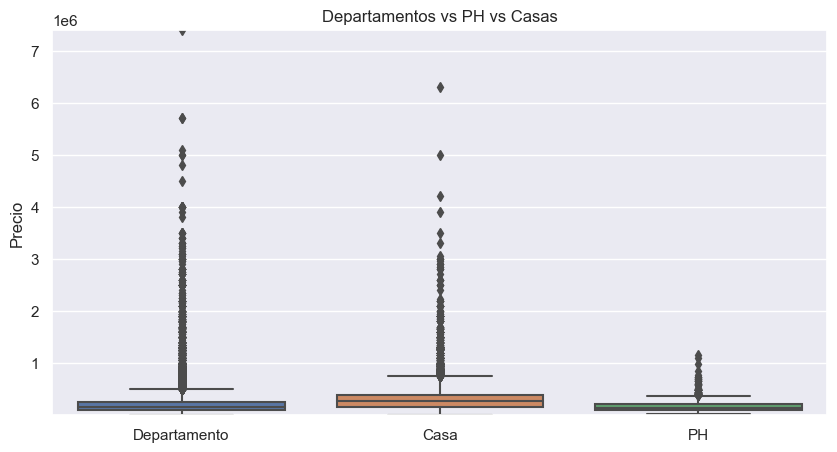

In [49]:
temp_data = df[['property_type','price']]
sns.set(style="darkgrid")  

fig, ax = plt.subplots(figsize=(10,5))
temp_data = temp_data[(temp_data['property_type'] == 'Departamento') | (temp_data['property_type'] == 'Casa') | (temp_data['property_type'] == 'PH')]
g = sns.boxplot(x='property_type',y='price',data=temp_data)
g.set(ylim=(df['price'].min(),df['price'].max()))
plt.title("Departamentos vs PH vs Casas")
plt.ylabel('Precio')
plt.xlabel('')

Text(0, 0.5, '')

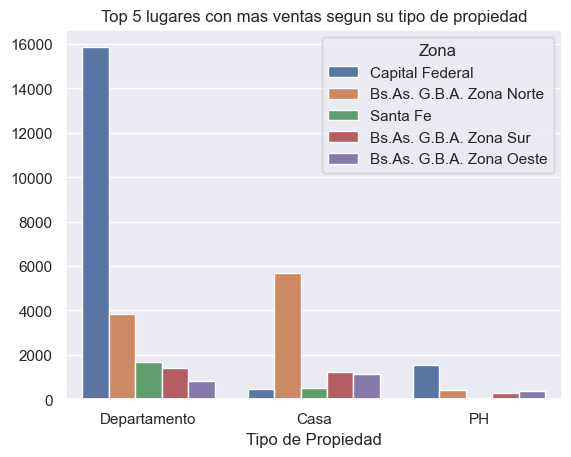

In [50]:
top_5_lugares_con_mas_ventas = df.groupby(["l2","property_type"]).count().reset_index()
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[['l2','property_type','id']]
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[(top_5_lugares_con_mas_ventas['l2'] == 'Capital Federal') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Sur') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Norte') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Oeste') | (top_5_lugares_con_mas_ventas['l2'] == 'Santa Fe')]
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[(top_5_lugares_con_mas_ventas['property_type'] == 'Departamento') | (top_5_lugares_con_mas_ventas['property_type'] == 'Casa') | (top_5_lugares_con_mas_ventas['property_type'] == 'PH')]

top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas.sort_values(by=['id'],ascending=False)
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas.rename(columns={'l2':'Zona'})

sns.barplot(data=top_5_lugares_con_mas_ventas,x='property_type',y='id',hue='Zona')
plt.title("Top 5 lugares con mas ventas segun su tipo de propiedad")
plt.xlabel('Tipo de Propiedad')
plt.ylabel("")

<AxesSubplot:xlabel='price', ylabel='l3'>

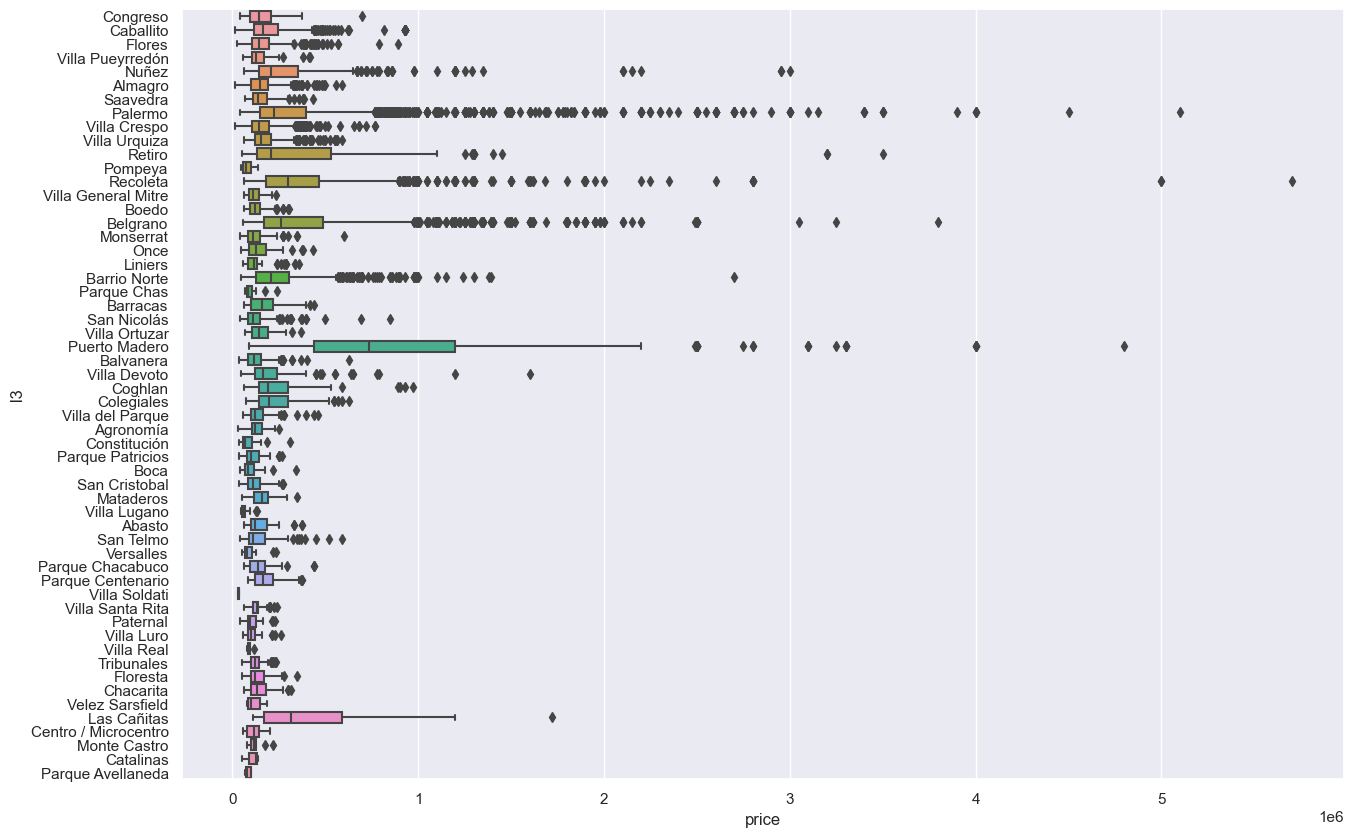

In [51]:
temp = df[(df['property_type'] == 'Departamento') & (df['l2'] == 'Capital Federal')]

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=temp,x='price',y='l3',orient='h')

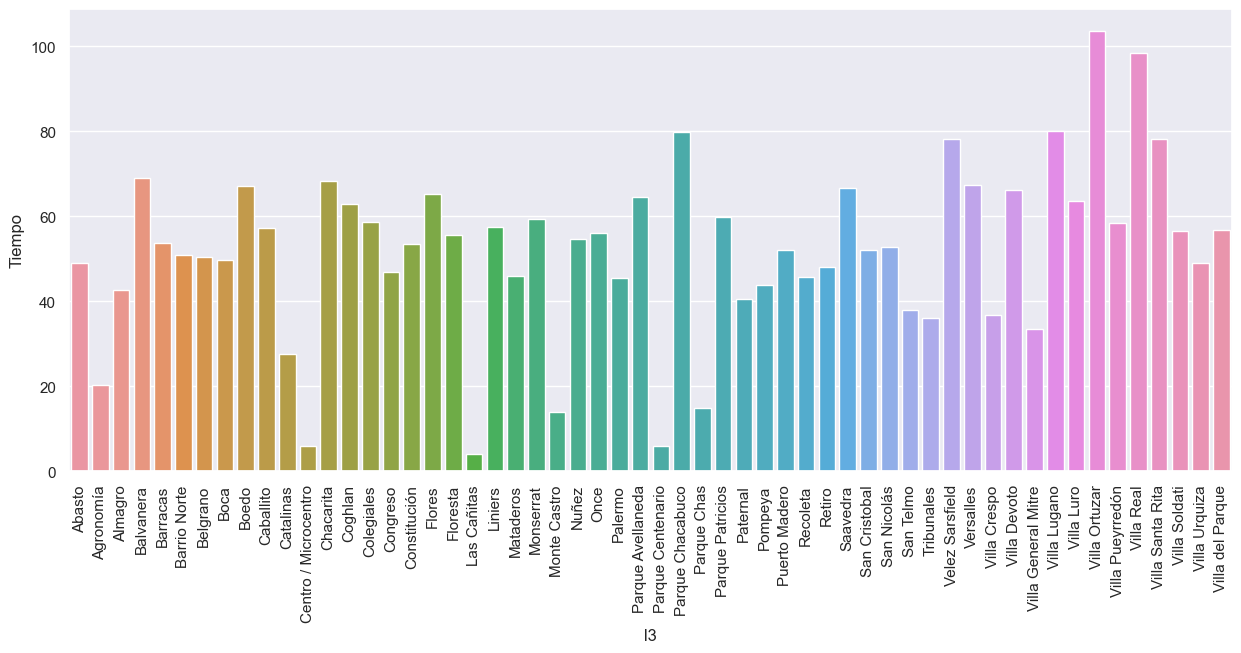

In [52]:
temporal = temp.groupby("l3").mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(data=temporal,x='l3',y='Tiempo')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.show()


Filtro los datos para averiguar si hay correlaciones entre el precio de los departamentos y Capital Federal ya que es donde mas departamentos se venden

In [53]:
df = df[(df['l2'] == 'Capital Federal')]
df = df[(df['property_type'] == 'Departamento')]

Analizamos que columnas necesitamos y que podemos borrar

In [54]:
df.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2',
       'l3', 'l4', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'finalizo_anuncio',
       'Tiempo'],
      dtype='object')

In [55]:
df = df.drop(columns=['created_on','l4','description','lat','lon','bedrooms','currency','title'])

df.columns

Index(['id', 'start_date', 'end_date', 'l1', 'l2', 'l3', 'rooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'price_period',
       'property_type', 'operation_type', 'finalizo_anuncio', 'Tiempo'],
      dtype='object')

Segun lo que vimos en el analisis exploratorio tenemos muchos outliers y eso nos puede afectar en el analisis, vamos a analizar que pasa con outliers y sin outliers


<AxesSubplot:xlabel='price', ylabel='l3'>

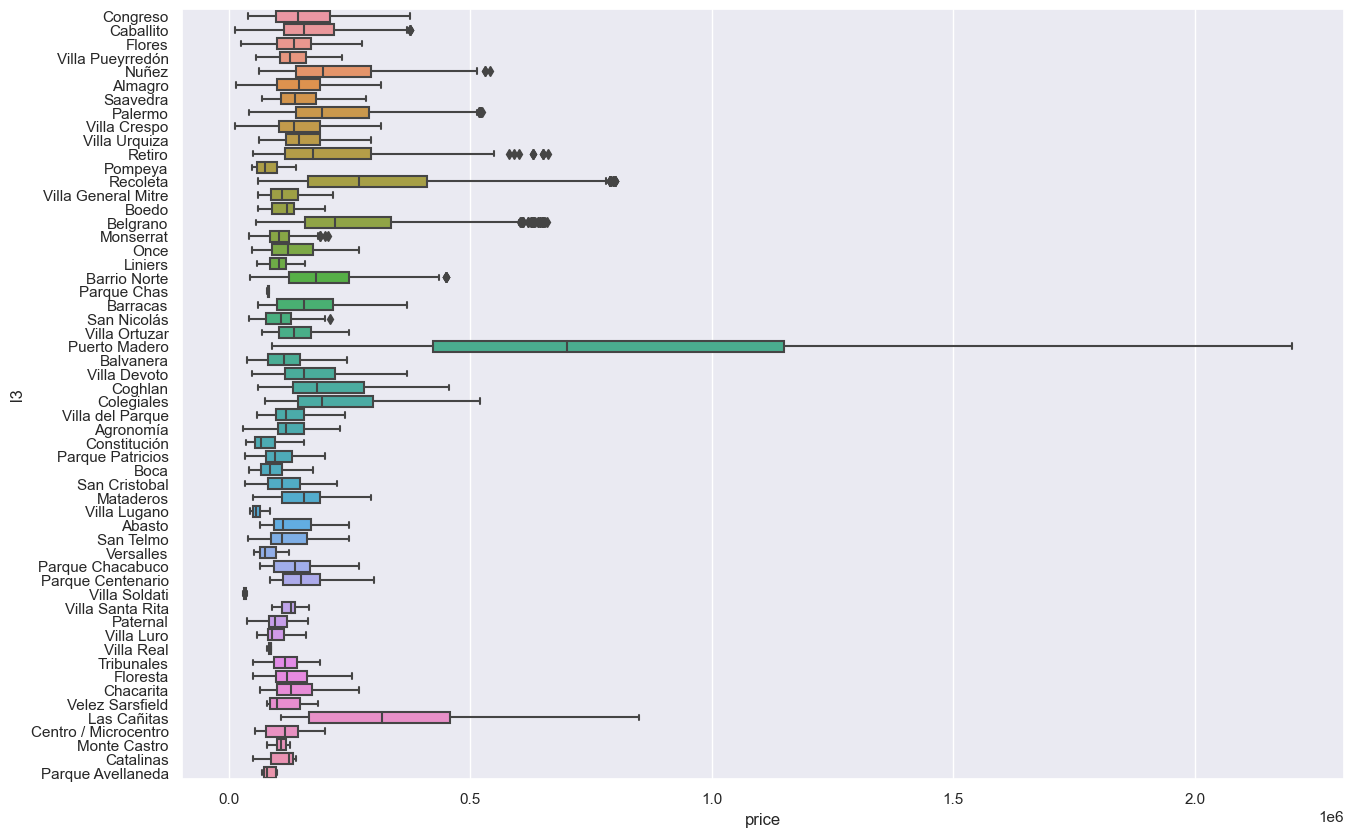

In [136]:
#Data sin outliers
fig, ax = plt.subplots(figsize=(15, 10))
l3 = df['l3'].unique()
df_sin_outliers = df
df_final = pd.DataFrame()
df_final2 = pd.DataFrame()
df_final3 = pd.DataFrame()

def outliers(df,i,feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

for i in l3:
    i = str(i)
    upper, lower = outliers(df[df['l3']==i],i,"price") 
    #print(i,': ',upper)
    df_final = pd.concat([df_final,df[(df['l3'] == i) & (df['price'] < upper) & (df['price'] > lower)]])
    
for i in l3:
    i = str(i)
    upper, lower = outliers(df_final[df_final['l3']==i],i,"price") 
    #print(i,': ',upper)
    df_final2 = pd.concat([df_final2,df_final[(df_final['l3'] == i) & (df_final['price'] < upper) & (df_final['price'] > lower)]])

for i in l3:
    i = str(i)
    upper, lower = outliers(df_final2[df_final2['l3']==i],i,"price") 
    #print(i,': ',upper)
    df_final3 = pd.concat([df_final3,df_final2[(df_final2['l3'] == i) & (df_final2['price'] < upper) & (df_final2['price'] > lower)]])


sns.boxplot(data=df_final3,x='price',y='l3',orient='h')



Debimos hacer muchas iteraciones para sacar la mayor cantidad de ouliers

Con Outliers

In [142]:
model1 = 'price~l3'
lm1   = sm.ols(formula = model1, data = df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     62.98
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:50:37   Log-Likelihood:            -2.2322e+05
No. Observations:               15804   AIC:                         4.465e+05
Df Residuals:                   15748   BIC:                         4.470e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [141]:
model1 = 'price~l3'
lm1   = sm.ols(formula = model1, data = df_final3).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     200.4
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:50:01   Log-Likelihood:            -1.8555e+05
No. Observations:               14093   AIC:                         3.712e+05
Df Residuals:                   14037   BIC:                         3.716e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

La interpretacion que obtenemos sobre este modelo es que hay una gran diferencia entre tener o no tener outliers, casi un 30%, pero aun asi es poco un 0.44

Con Ouliers

In [143]:
model1 = 'price~rooms + bathrooms + surface_total + surface_covered'
lm1   = sm.ols(formula = model1, data = df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     3608.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:51:49   Log-Likelihood:            -2.2040e+05
No. Observations:               15858   AIC:                         4.408e+05
Df Residuals:                   15853   BIC:                         4.409e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.419e+05   5335.359    -

Sin Outliers

In [145]:
model1 = 'price~rooms + bathrooms + surface_total + surface_covered'
lm1   = sm.ols(formula = model1, data = df_final3).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     2473.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:52:20   Log-Likelihood:            -1.8589e+05
No. Observations:               14093   AIC:                         3.718e+05
Df Residuals:                   14088   BIC:                         3.718e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.822e+04   3145.924    -

En este caso parece haber cierta correlacion entre el precio y las caracteristicas de una propiedad con o sin outliers,el hecho de que haya tanta variabilidad en el precio nos hace suponer que el R-squared es 0.47 y 0.41,y no uno mas alto por la variabilidad alta del precio, en cambio, si la variabilidad en el precio fuese mas baja, asumimos que la correlacion seria mas alta.

# Conclusiones

Como punto de partida estamos en Argentina donde los precios cambian constantemente y eso hace que sea complicado poder predecir con exactitud, pero aceptando eso de entrada, podemos notar que:

- El precio no tiene correlacion con el tiempo que estuvieron en el mercado
- Sabemos que zona es donde mas se vendieron propiedades, especificamente departamentos, en Capital Federal, suponemos por la gran cantidad de edificios
- Las zonas donde mas rapido se vendieron departamentos en promedio son: Centro/Microcentro, Las Cañitas y Parque centenario

Entonces respondiendo a la pregunta, en el Centro/Microcentro, Las Cañitas y Parque Centenario son los lugares en Capital Federal donde mas rapido se venden los departamentos.

Vale agregar lo siguiente, en las zonas donde mas variabilidad del precio es donde mas caras son, Puerto madero, Las cañitas, Belgrano por ejemplo. Esto nos pone en comun una locacion en particular, Las Cañitas, que parece ser una zona donde mas rapido se venden los departamentos y en media son uno de los mas caros. Esto tiene muy poco de analisis predictivo cientifico, si queremos apuntar a un analisis de prediccion nos serviria un modelo de aprendizaje supervizado, pero para esto habria que hacerlo en los barrios de menos variabilidad que resultan ser los menos caros. Podemos probar hacer un modelo de regresion lineal multivariable donde las columnas mas importantes que podemos seleccionar son, baños, cantidad de ambientes , metros cuadrados y metros cubiertos.

Lamentablemente si queremos ser mas especificos y predictivos en el mercado inmobiliario argentino hay que apuntar a zonas con menor variabilidad de precio a pesar del coste economico que conlleva